# Conversational ChatBot - Part 2

# 1. Load Data to Colab

In [1]:
import numpy as np
import pickle
import random
import os
import yaml
import matplotlib.pyplot as plt

In [2]:
from keras.preprocessing import text, sequence
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model, load_model

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/chatbot

In [6]:
files = os.listdir('data/')

In [7]:
categories = list()
questions = list()
answers_raw = list()

for file in files:
  docs = yaml.safe_load(open('data/' + file, 'r')) 
  conversations = docs['conversations']
  for cur_con in conversations:
    if len(cur_con) > 2:
      for ans in cur_con[1: ]:
        categories.append(docs['categories'][0])
        questions.append(cur_con[0])
        answers_raw.append(ans)
      #questions.append(cur_con[0])
      #answers_raw.append(' '.join(cur_con[1: ]))
    elif len(cur_con) == 2:
      if type( cur_con[1] ) == str: # Filter out unexpected input format
        categories.append(docs['categories'][0])
        questions.append(cur_con[0])
        answers_raw.append(cur_con[1])

# 2. Data Preprocessing

In [8]:
START_TAG = 'starttag'
END_TAG = 'endtag'

In [9]:
answers = list()
for i in range(len(answers_raw)) :
    answers.append(START_TAG + ' ' + answers_raw[i] + ' ' + END_TAG)

In [10]:
tokenizer = text.Tokenizer() 
tokenizer.fit_on_texts(questions + answers)

In [11]:
# Construct reverse word index for model inference
reverse_tokenizer_word_index = {v: k for k, v in tokenizer.word_index.items()}

In [12]:
# 在这里把size加1的原因是: 我们在后续做padding的时候, 会把empty word作为一个单独的情况处理，即index0
vocab_with_padding_size = len(tokenizer.word_index) + 1

2.1. 利用questions构造encoder的输入数据

In [13]:
# encoder_input_data
tokenized_questions = tokenizer.texts_to_sequences(questions)
maxlen_questions = max([len(question) for question in tokenized_questions])

In [14]:
padded_questions = sequence.pad_sequences(tokenized_questions , maxlen=maxlen_questions , padding='post')
encoder_input_data = np.array(padded_questions)
print("encoder_input_data: ", encoder_input_data.shape, ". max length is: ", maxlen_questions)

encoder_input_data:  (870, 22) . max length is:  22


2.2. 利用answers数据构造decoder的输入数据

In [15]:
# decoder_input_data
tokenized_answers = tokenizer.texts_to_sequences(answers)
maxlen_answers = max([len(answer) for answer in tokenized_answers])

In [16]:
padded_answers = sequence.pad_sequences(tokenized_answers, maxlen=maxlen_answers, padding='post')
decoder_input_data = np.array(padded_answers)
print("decoder_input_data: ", decoder_input_data.shape ,". max length is: ", maxlen_answers)

decoder_input_data:  (870, 60) . max length is:  60


2.3. 利用answers数据构造decoder的输出数据

In [17]:
# decoder_output_data 它的构造方法是：把answers句子的第一个单词删掉，得到一个新句子。
tokenized_answers = tokenizer.texts_to_sequences(answers)
for i in range(len(tokenized_answers)) :
    tokenized_answers[i] = tokenized_answers[i][1:]
padded_answers = sequence.pad_sequences( tokenized_answers , maxlen=maxlen_answers , padding='post' )

In [18]:
# convert decoder output to categorical format
onehot_answers = to_categorical( padded_answers , vocab_with_padding_size) 
decoder_output_data = np.array(onehot_answers)
print("decoder_output_data: ", decoder_output_data.shape)

decoder_output_data:  (870, 60, 2018)


#3. Build Seq2Seq Model

In [19]:
EMBEDDING_DIM = 200

In [20]:
encoder_inputs = Input(shape=(maxlen_questions,))
encoder_embedding = Embedding(input_dim=vocab_with_padding_size, output_dim=EMBEDDING_DIM, mask_zero=True)(encoder_inputs) 
encoder_lstm = LSTM(units=EMBEDDING_DIM, return_state=True)
_, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h , state_c]

In [21]:
decoder_inputs = Input(shape=(maxlen_answers, ))
decoder_embedding = Embedding(input_dim=vocab_with_padding_size, output_dim=EMBEDDING_DIM, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(units=EMBEDDING_DIM, return_state=True , return_sequences=True)
decoder_outputs, _ ,_ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

In [22]:
decoder_dense = Dense(units=vocab_with_padding_size, activation='softmax')
dense_output = decoder_dense(decoder_outputs)

In [23]:
model = Model([encoder_inputs, decoder_inputs], dense_output)
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 22)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 22, 200)      403600      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 60, 200)      403600      ['input_2[0][0]']                
                                                                                              

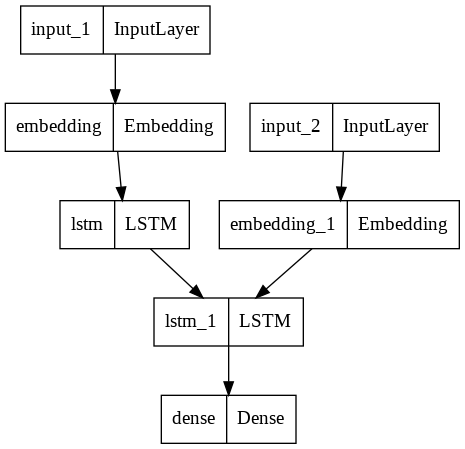

In [25]:
plot_model(model)

In [ ]:
# 在程序开发过程中，为了提高效率，我们可以在这里适当减小epochs取值。若设置epochs=300，则需用约46mins完成该参数更新过程.
%time history = model.fit([encoder_input_data , decoder_input_data], decoder_output_data, batch_size=50, epochs=300 ) # 为了加速程序运行，可以把参数改成 epochs=10

Epoch 1/300
18/18 [==============================] - 16s 502ms/step - loss: 1.3088
Epoch 2/300
18/18 [==============================] - 9s 500ms/step - loss: 1.0804
Epoch 3/300
18/18 [==============================] - 9s 501ms/step - loss: 1.0348
Epoch 4/300
18/18 [==============================] - 9s 514ms/step - loss: 0.9624
Epoch 5/300
18/18 [==============================] - 9s 503ms/step - loss: 0.9686
Epoch 6/300
18/18 [==============================] - 9s 498ms/step - loss: 0.9140
Epoch 7/300
18/18 [==============================] - 9s 501ms/step - loss: 0.8797
Epoch 8/300
18/18 [==============================] - 9s 503ms/step - loss: 0.9153
Epoch 9/300
18/18 [==============================] - 9s 507ms/step - loss: 0.8592
Epoch 10/300
18/18 [==============================] - 9s 504ms/step - loss: 0.8994
Epoch 11/300
18/18 [==============================] - 9s 505ms/step - loss: 0.8297
Epoch 12/300
18/18 [==============================] - 9s 505ms/step - loss: 0.8522
Epoch 13/300

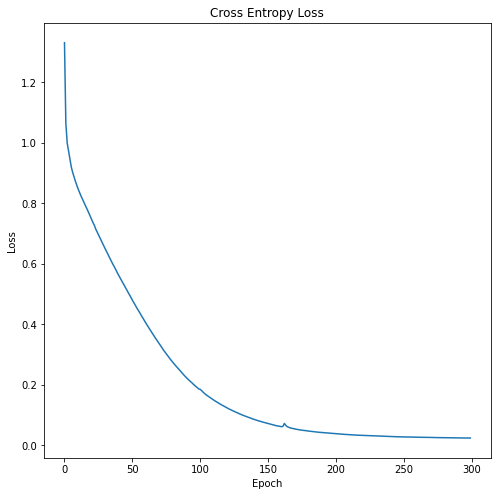

In [ ]:
%matplotlib inline
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.title('Cross Entropy Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

#4. (Optional) Save Model and Related Params for Chatbot GUI Development

In [ ]:
model.save('my_seq2seq_model.h5')

In [ ]:
save_params = {}
save_params['tokenizer'] = tokenizer
save_params['reverse_tokenizer_word_index'] = reverse_tokenizer_word_index
save_params['maxlen_questions'] = maxlen_questions
save_params['maxlen_answers'] = maxlen_answers
save_params['EMBEDDING_DIM'] = EMBEDDING_DIM
save_params['START_TAG'] = START_TAG
save_params['END_TAG'] = END_TAG

In [ ]:
pickle.dump(save_params, open('my_save_params_seq2seq.pkl','wb'))

#5. Load Model and Related Params

In [26]:
# Load models
classification_model = load_model('classification_model.h5')
seq2seq_model = load_model('seq2seq_model.h5')

# Load saved parameters
save_params = pickle.load(open('save_params_seq2seq.pkl','rb'))
save_params_classification = pickle.load(open('save_params_classification.pkl','rb'))

In [27]:
# Load language processing params
tokenizer = save_params['tokenizer']
reverse_tokenizer_word_index = save_params['reverse_tokenizer_word_index']
maxlen_questions = save_params['maxlen_questions']
maxlen_answers = save_params['maxlen_answers']
EMBEDDING_DIM = save_params['EMBEDDING_DIM']
START_TAG = save_params['START_TAG']
END_TAG = save_params['END_TAG']
categories_list = save_params_classification['categories_list']  
class_tokenizer = save_params_classification['tokenizer']

# Load seq2seq model params
encoder_inputs = seq2seq_model.layers[0].input
encoder_states = seq2seq_model.layers[4].output[1:]
decoder_inputs = seq2seq_model.layers[1].input
decoder_lstm = seq2seq_model.layers[5]
decoder_embedding = seq2seq_model.layers[3].output
decoder_dense = seq2seq_model.layers[6]

#6. Model Inference

In [28]:
encoder_model = Model(encoder_inputs, encoder_states) 
decoder_state_input_h = Input(shape=(EMBEDDING_DIM ,))
decoder_state_input_c = Input(shape=(EMBEDDING_DIM ,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding , initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [29]:
for _ in range(6):
  # Take and parse input question
  q_input = input('Please enter question: ')
  tokenized_questions = tokenizer.texts_to_sequences([q_input])
  parsed_q_input = sequence.pad_sequences(tokenized_questions , maxlen=maxlen_questions , padding='post')

  # Make inference with seq2seq model
  states_values = encoder_model.predict(parsed_q_input)
  empty_target_seq = np.zeros((1,1))
  empty_target_seq[0, 0] = tokenizer.word_index[START_TAG]
  decoded_translation = ''
  while True :
      dec_outputs , h , c = decoder_model.predict([empty_target_seq] + states_values)
      sampled_word_index = np.argmax( dec_outputs[0, 0, :] ) 
      if sampled_word_index in reverse_tokenizer_word_index:
          word = reverse_tokenizer_word_index[sampled_word_index]
          if word == END_TAG or len(decoded_translation.split()) >= maxlen_answers:
            break
          else:
            decoded_translation += ' {}'.format( word )
      empty_target_seq[ 0 , 0 ] = sampled_word_index
      states_values = [ h , c ]
  print('Techie Chatbot:', decoded_translation)

Please enter question: How are you?
Techie Chatbot:  i am doing well
Please enter question: Tell me a joke, please
Techie Chatbot:  what do you get when you cross a cat and a purple person
Please enter question: What do you eat?
Techie Chatbot:  i use electricity to function if that counts
Please enter question: Do you eat meat?
Techie Chatbot:  no i'm just a piece of software
Please enter question: Are you angry?
Techie Chatbot:  i have not yet studied how to feel or express anger
Please enter question: What is AI?
Techie Chatbot:  ai is the field of science which concerns itself with building hardware and software that replicates the functions of the human mind


#7. (Optional) Develop GUI Chatbot on your local machine

使用python GUI工具开发Chatbot图形用户界面(如下图所示)。在[Techie数据科学集训营](https://www.techielearning.com/data-science-class)中，教师会讲解相关`chatbot_GUI.py`代码。

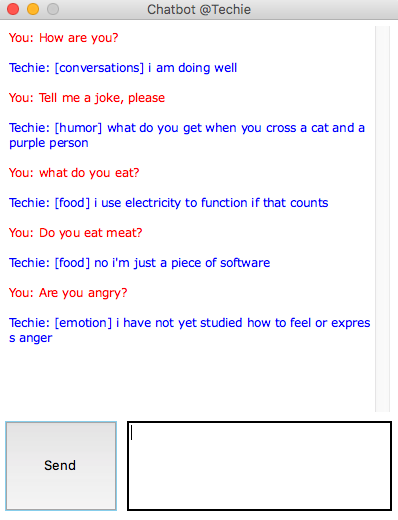